# Identifying junk in the large-galaxy atlas

The goal of this notebook is to investigate the junk in the parent (Hyperleda) large-galaxy sample, so it can be culled (in `LSLGA-build-parent`).

In [1]:
import os
import numpy as np

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.8, palette='Set2')
import matplotlib.pyplot as plt

In [34]:
from astrometry.libkd.spherematch import tree_build_radec, tree_search_radec

In [22]:
import LSLGA.io
import LSLGA.misc

In [4]:
%matplotlib inline

In [5]:
pp = LSLGA.io.read_hyperleda(verbose=True, version='v2.0')
pp = pp[np.isfinite(pp['MAG'])]
pp

Read 1436176 objects from /Users/ioannis/research/projects/LSLGA/sample/v2.0/hyperleda-d25min10-18nov14.fits
Read 1436176 objects from /Users/ioannis/research/projects/LSLGA/sample/v2.0/hyperleda-d25min10-18nov14-allwise.fits
  Identified 1379531/1436176 (96.06%) objects with AllWISE photometry.


GALAXY,PGC,OBJTYPE,RA,DEC,TYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,BT,VT,IT,KT,MODBEST,DIAM_ISO,BA_ISO,DIAM_B,BA_B,DIAM_V,BA_V,DIAM_R,BA_R,DIAM_I,BA_I,DIAM_K,BA_K,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE
bytes29,int64,bytes1,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
PGC2400369,2400369,G,132.204828,51.8015943,S?,nan,nan,nan,nan,10.0,34.78,17.896,nan,16.932,nan,38.193,0.27605778,0.8147043,0.11371283,1.0407331,nan,nan,0.1037752,1.1072323,0.10651638,1.1385304,nan,nan,0.27605778,0.8147043,iso,0.09548706,23.72948,17.896,B,132.2047809,51.8015554,1311151401351051099,14.799,0.032,14.505,0.053,10.649,0.087,9.124,0.527,1.256,0000,0,AAAC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True
PGC1488598,1488598,G,222.915693,15.5919184,Sbc,nan,nan,nan,nan,4.1,nan,17.264,nan,15.966,13.271,38.723,0.28444612,0.9078205,0.0849317,1.191905,nan,nan,0.0781667,1.3165858,0.07033627,1.5420105,0.1733804,0.62661386,0.28444612,0.9078205,iso,0.120433316,23.162481,17.264,B,222.9157868,15.5920402,2222115101351049361,13.279,0.024,12.983,0.026,9.087,0.026,6.899,0.078,2.226,0000,5,AAAA,0.83,9.73,0.95,45.0,13.315,0.01,13.066,0.018,9.626,0.018,7.595,0.086,True
PGC1283207,1283207,G,228.3770865,5.4232017,S?,nan,nan,nan,nan,0.9,152.2,16.976,nan,15.514,13.174,35.943,0.36307806,0.724436,0.10114144,2.2749133,nan,nan,0.10000527,2.3741608,0.094467476,2.473992,0.24660392,0.724436,0.36307806,0.724436,iso,0.03463229,23.40448,16.976,B,228.3771822,5.4228275,2278106001351000050,13.453,0.039,13.393,0.045,11.785,0.242,8.741,nan,1.088,0000,4,AABU,0.95,9.75,0.73,-25.0,13.27,0.01,13.334,0.02,12.209,0.183,10.103,0.835,True
PGC1310416,1310416,G,202.54443750000002,6.9345944,Sc,nan,nan,M,nan,4.7,159.26,16.85,nan,15.526,13.196,37.612,0.4017908,0.7816278,0.15194553,0.9835427,nan,nan,0.14944077,0.989217,0.1445308,1.0379881,0.26001596,0.64120954,0.4017908,0.7816278,iso,0.073888786,23.498482,16.85,B,202.5444539,6.9345167,2028107501351007858,13.282,0.025,13.109,0.028,9.197,0.03,7.024,0.098,2.075,0000,5,AAAA,0.51,9.36,0.79,-10.0,13.214,0.01,13.069,0.021,9.695,0.024,7.485,0.104,True
SDSSJ145059.93+135143.0,4435547,G,222.749787,13.8619111,S?,nan,nan,nan,nan,5.0,44.57,18.214,nan,17.07,nan,37.67,0.33342642,0.6637431,nan,nan,nan,nan,0.14096962,1.0607271,0.13530913,1.0226746,nan,nan,0.33342642,0.6637431,iso,0.07567602,24.457481,18.214,B,222.7496762,13.8620163,2234113601351039304,14.829,0.029,14.596,0.049,11.637,0.165,8.57,nan,1.155,0000,0,AABU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True
PGC989399,989399,G,358.77663900000005,-9.5653116,S?,nan,nan,nan,nan,5.0,175.99,17.703,nan,16.691,nan,36.923,0.3311311,0.82794213,0.19530682,0.57800263,nan,nan,0.17983368,0.59576225,0.17189074,0.6998507,nan,nan,0.3311311,0.82794213,iso,0.054968026,23.93148,17.703,B,358.7768097,-9.5652868,3584009101351002728,15.181,0.039,14.948,0.072,12.025,0.307,9.096,nan,1.337,0000,0,AABU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True
PGC2336968,2336968,G,230.948838,49.227853499999995,nan,nan,nan,nan,nan,nan,156.19,18.953,nan,17.009,14.518,39.802,0.29241523,0.74131024,0.09516256,2.837301,nan,nan,0.0826084,2.9310102,0.06970474,3.8450315,nan,nan,0.29241523,0.74131024,iso,0.1910028,24.91148,18.953,B,230.94891,49.2278026,2299149901351000040,13.795,0.024,13.459,0.026,10.504,0.054,8.431,0.184,1.31,0000,0,AAAB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True
PGC1742504,1742504,G,182.0888085,25.6

### Compare optical and AllWISE diameters

To do this comparison we require W1RSEMI to be measured, which is only done if the WISE source is within 2 arcsec of a 2MASS/XSC galaxy.  See:
* http://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec5_3bvii.html#xsc
* http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4c.html#xsc

In [6]:
w1 = np.where( (pp['CNTR'] != -1) )[0]
w2 = np.where( np.isfinite(pp['W1RSEMI'][w1]) )[0]
print('{:.2f}% galaxies in AllWISE, {:.2f}% with measured WISE/2MASS diameters.'.format(
    100*len(w1)/len(pp), 100*len(w2)/len(w1)))

96.58% galaxies in AllWISE, 24.16% with measured WISE/2MASS diameters.


This agreement isn't crazy. Basically the D(25) diameters are much larger than the isophotal IR diameters.  However, we should probably look into the sources that are small in the optical and big in the IR.

(0, 3)

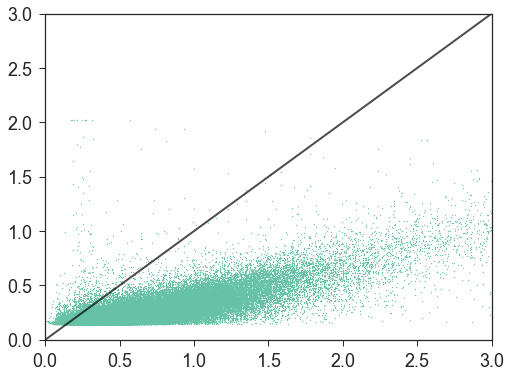

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pp['D25'][w1][w2], pp['W1RSEMI'][w1][w2]/60, s=1)
ax.plot([-1, 5], [-1, 5], lw=2, ls='-', color='k', alpha=0.7)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

### Find galaxies that are large in the optical but unresolved in AllWISE/2MASS

We know the catalog contains spuriously large "galaxies", e.g., due to filter reflections in the SDSS imaging.  The strategy here is to find "large" objects that WISE says are unresolved.

In [8]:
j1 = np.where( (pp['CNTR'] != -1) )[0]
#j2 = np.where( np.isnan(pp['W1RSEMI'][j1]) )[0] # this depends on being close to a 2MASS source
j2 = np.where( pp['EXT_FLG'][j1] == 0 )[0] # this depends on the WISE PSF only
print('{:.2f}% galaxies in AllWISE, {:.2f}% are unresolved.'.format(100*len(j1)/len(pp), 100*len(j2)/len(j1)))

96.58% galaxies in AllWISE, 59.86% are unresolved.


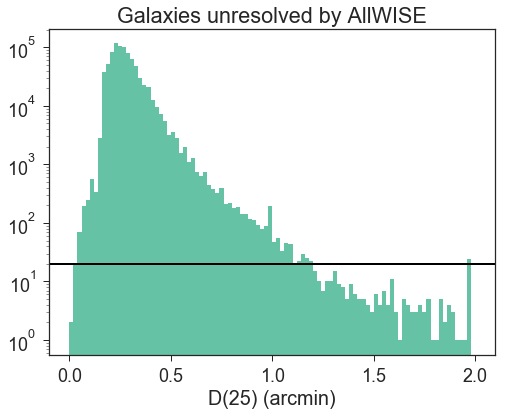

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
_ = ax.hist(pp['D25'][j1][j2], bins=100, range=(0, 2), log=True)
            #cumulative=True, histtype='step', lw=2, density=True)
ax.axhline(y=20, lw=2, color='k')
ax.set_xlabel('D(25) (arcmin)')
_ = ax.set_title('Galaxies unresolved by AllWISE')

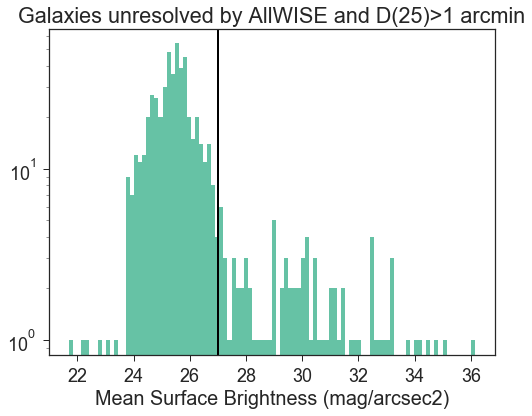

In [10]:
j3 = np.where( (pp['D25'][j1][j2] > 1.0) )[0]
#pp['GALAXY', 'PGC', 'RA', 'DEC', 'TYPE', 'D25', 'DIAM_REF', 'MAG', 'MAG_REF', 'SB_D25'][j1][j2][j3]
fig, ax = plt.subplots(figsize=(8, 6))
_ = ax.hist(pp['SB_D25'][j1][j2][j3], bins=100, log=True)#, range=(0, 3), log=True)
ax.axvline(x=27, lw=2, color='k')
ax.set_xlabel('Mean Surface Brightness (mag/arcsec2)')
_ = ax.set_title('Galaxies unresolved by AllWISE and D(25)>1 arcmin')

#### The figure below is interesting:
1. Galaxies with D(25)<10 arcsec are almost exclusively from the SDSS: they have half-light radii but not isophotal radii. We will likely reject these from the large-galaxy sample because Tractor does reasonably well on them.
2. There's a spur of galaxies with D(25)~0.98 arcmin. Based on previous visual inspection, these are almost all from the SDSS and are cases where the Petrosian fitting failed (e.g., because of a filter reflection).  Reject these.
3. I think all the galaxies with D(25)>0.95 arcmin and SB>27 mag/arcsec2 are also spurious or at least suspect.  This cut will likely reject bona fide low surface brightness dwarf galaxies, but I don't think we want them in the sample anyway (e.g., as large-galaxy priors).

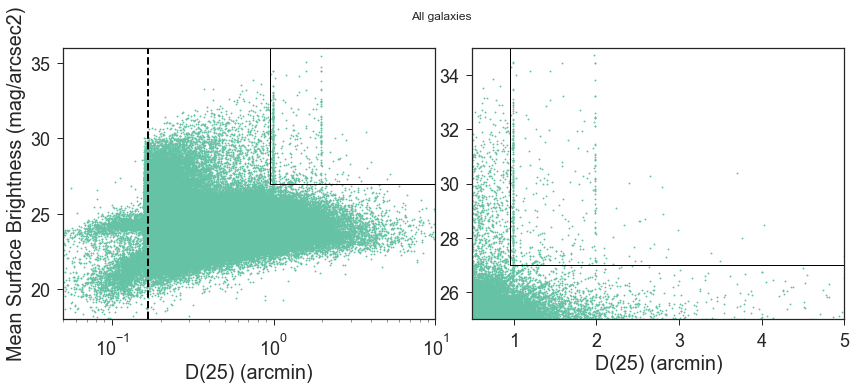

In [11]:
def plotbox(ax):
    ax.plot([0.95, 1000], [27, 27], color='k', lw=1)
    ax.plot([0.95, 0.95], [27, 40], color='k', lw=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))#, sharey=True)
if False:
    ax1.scatter(pp['D25'][j1][j2], pp['SB_D25'][j1][j2], s=2)
    ax2.scatter(pp['D25'][j1][j2], pp['SB_D25'][j1][j2], s=2)
else:
    ax1.scatter(pp['D25'], pp['SB_D25'], s=2)
    ax2.scatter(pp['D25'], pp['SB_D25'], s=2)
ax1.set_xlim(0.05, 10)
ax1.set_ylim(18, 36)
ax1.set_xscale('log')
ax1.set_ylabel('Mean Surface Brightness (mag/arcsec2)')
for ax in (ax1, ax2):
    ax.axvline(x=10/60, lw=2, ls='--', color='k')
    ax.set_xlabel('D(25) (arcmin)')
    plotbox(ax)

ax2.set_xlim(0.5, 5)
ax2.set_ylim(25, 35)
if False:
    fig.suptitle('Galaxies unresolved by AllWISE')
else:
    fig.suptitle('All galaxies')

fig.subplots_adjust(wspace=0.1)

### Here are the galaxies culled by our $D(25)>0.95$ arcmin & $SB_{25}>27$ mag/arcsec2 cut:

Notice the sample is only about 500 objects.

In [12]:
cut = np.where( (pp['D25'] > 0.95) * (pp['SB_D25'] > 27) )[0]
#print(pp[cut]['GALAXY'].data)
pp['GALAXY', 'PGC', 'RA', 'DEC', 'TYPE', 'D25', 'DIAM_REF', 'MAG', 'MAG_REF', 'SB_D25', 'EXT_FLG', 'IN_ALLWISE'][cut]

GALAXY,PGC,RA,DEC,TYPE,D25,DIAM_REF,MAG,MAG_REF,SB_D25,EXT_FLG,IN_ALLWISE
bytes29,int64,float64,float64,bytes4,float32,bytes3,float32,bytes1,float32,int32,bool
SDSSJ121818.83+030840.9,4002247,184.5785745,3.144682,nan,1.573983,iso,17.894,B,27.50748,0,True
SDSSJ054946.55+010106.5,5419567,87.4439805,1.0184809000000001,nan,0.98902357,r,22.847,B,31.451513,0,True
SDSSJ150517.82+194512.6,5253750,226.3242885,19.7535038,nan,1.9779667,r,20.775,B,30.884575,0,False
SDSSJ090110.10+203654.3,5613232,135.2920875,20.6150919,nan,0.9890164,r,22.808,B,31.412498,0,False
SDSSJ144209.94+023852.5,6042859,220.5414375,2.6479211,nan,0.9889367,r,23.145,B,31.749325,0,True
SDSSJ122816.27+563209.4,6598337,187.06783049999999,56.5359527,nan,1.8344285,r,20.33,B,30.275986,0,False
SDSSJ154517.92+153537.7,5226655,236.32469700000001,15.5938115,nan,0.98497134,r,19.413,B,28.008598,0,True
SDSSJ132727.80+212607.7,5081852,201.86587200000005,21.4354962,nan,1.9780824,r,18.301,B,28.410704,0,False
SDSSJ112402.69-074710.3,5075535,171.011214,-7.7862113,nan,1.977742,r,22.011,I,32.120327,0,False


### Plot the cumulative fraction of galaxies above various angular diameter cuts.

Number (fraction) of galaxies with D(25)>0.50 arcmin: 174901/1422394 (12.296%)
Number (fraction) of galaxies with D(25)>0.75 arcmin: 52007/1422394 (3.656%)
Number (fraction) of galaxies with D(25)>1.00 arcmin: 21182/1422394 (1.489%)
Number (fraction) of galaxies with D(25)>1.50 arcmin: 6156/1422394 (0.433%)


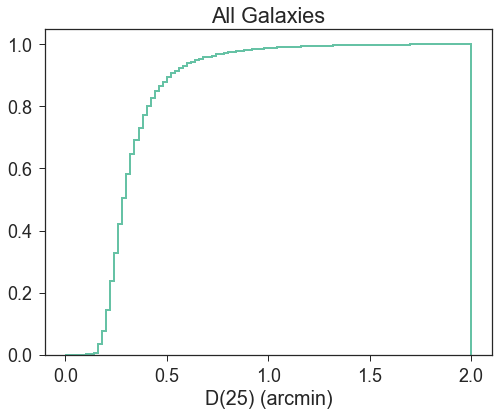

In [13]:
keep = np.delete( np.arange(len(pp)), cut )
#srt = np.argsort(pp['D25'][keep])
for d25cut in (0.5, 0.75, 1.0, 1.5):
    nn = np.sum( (pp['D25'][keep] > d25cut) )
    print('Number (fraction) of galaxies with D(25)>{:.2f} arcmin: {}/{} ({:.3f}%)'.format(
        d25cut, nn, len(keep), 100 * nn / len(keep) ))

fig, ax = plt.subplots(figsize=(8, 6))
_ = ax.hist(pp['D25'][keep], bins=100, range=(0, 2), #log=True,
            cumulative=True, histtype='step', lw=2, density=True)
ax.set_xlabel('D(25) (arcmin)')
_ = ax.set_title('All Galaxies')

### Inspect all the "SDSS" and "2MASS" galaxies, especially the largest ones.

In [25]:
tiles = LSLGA.io.read_desi_tiles()
%time indesi = LSLGA.misc.is_point_in_desi(tiles, pp['RA'], pp['DEC']).astype(bool)

In [27]:
lsbcut = (pp['SB_D25'] > 27) * (pp['D25'] > 0.95)
diamcut = pp['D25'] > 20/60
sample = pp[~lsbcut * diamcut * indesi]
print(len(sample))
%time kdsample = tree_build_radec(sample['RA'], sample['DEC'])

290431
CPU times: user 770 ms, sys: 16.4 ms, total: 786 ms
Wall time: 205 ms


In [41]:
issdss = np.array(['SDSS' in gg.decode('utf-8') for gg in sample['GALAXY'].data])
is2mass = np.array(['MASS' in gg.decode('utf-8') for gg in sample['GALAXY'].data])
print(np.sum(issdss), np.sum(is2mass))

30221 4


Here it's likely that many (all?) of the largest "SDSS" galaxies are spurious; check them.

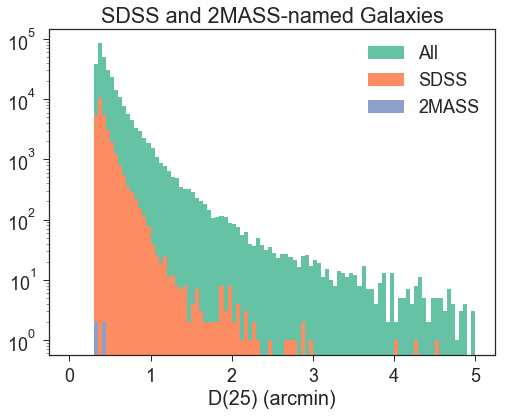

In [44]:
rest = np.logical_or( ~issdss, ~is2mass )
fig, ax = plt.subplots(figsize=(8, 6))
_ = ax.hist(sample['D25'][rest], bins=100, range=(0, 5), log=True, label='All')
_ = ax.hist(sample['D25'][issdss], bins=100, range=(0, 5), log=True, label='SDSS')
_ = ax.hist(sample['D25'][is2mass], bins=100, range=(0, 5), log=True, label='2MASS')
ax.legend(loc='upper right')
#ax.axhline(y=20, lw=2, color='k')
_ = ax.set_xlabel('D(25) (arcmin)')
_ = ax.set_title('SDSS and 2MASS-named Galaxies')

In [ ]:
ww = issdss * (sample['D25'] > 1)
print(np.sum(ww))
sdssgal = [gg.decode('utf-8') for gg in sample['GALAXY'][ww].data]
#print(sdssgal)
out = sample['RA', 'DEC', 'GALAXY'][ww]
out.rename_column('GALAXY', 'NAME')
#out.write('/Users/ioannis/Downloads/inspect.fits', overwrite=True)

### Flag all the SDSS galaxies inside other large galaxies.

In [57]:
verb = False
galingal = np.zeros( len(sample), dtype=bool)
for ss in sample:
    I = tree_search_radec(kdsample, ss['RA'], ss['DEC'], ss['D25'] / 2 / 60)
    if len(I) > 1:
        isdss = np.array(['SDSS' in gg for gg in sample['GALAXY'][I]])
        if np.sum(isdss) > 0:
            galingal[I[isdss]] = True
            if verb:
                print(sample[I]['GALAXY', 'RA', 'DEC', 'D25'])
                print('http://legacysurvey.org/viewer-dev?ra={:.5f}&dec={:.4f}&zoom=15&layer=ls-dr67&lslga'.format(
                    sample[I[0]]['RA'], sample[I[0]]['DEC']))
                import pdb ; pdb.set_trace()
print('  Found {}/{} ({:.2f}%) SDSS galaxies inside another large galaxy.'.format(
    np.sum(galingal), len(sample), 100*np.sum(galingal)/len(sample)))

  Found 2515/290431 (0.87%) SDSS galaxies inside another large galaxy.


In [59]:
sample[galingal]

GALAXY,PGC,OBJTYPE,RA,DEC,TYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,BT,VT,IT,KT,MODBEST,DIAM_ISO,BA_ISO,DIAM_B,BA_B,DIAM_V,BA_V,DIAM_R,BA_R,DIAM_I,BA_I,DIAM_K,BA_K,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE
bytes29,int64,bytes1,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
SDSSJ131611.48+305707.6,5075513,G,199.047867,30.952114299999998,S?,nan,nan,nan,nan,5.0,19.82,16.085,nan,nan,nan,34.647,nan,nan,0.9890496,0.15917355,nan,nan,0.9888686,0.19325401,0.14484046,1.2694402,nan,nan,0.9888686,0.19325401,r,0.01885471,24.689173,16.085,B,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
SDSSJ114243.26+240933.1,4536140,G,175.68032399999998,24.159240899999997,Sab,nan,nan,M,nan,1.5,172.72,18.752,nan,16.933,nan,38.789,0.3349654,0.8147043,0.014349247,6.9705925,nan,nan,0.015853161,7.0734396,0.015238909,6.9094105,nan,nan,0.3349654,0.8147043,iso,0.12403313,25.005482,18.752,B,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
SDSSJ021941.16-001535.2,5076163,G,34.9215405,-0.2597845,nan,nan,nan,nan,nan,nan,43.8,17.719,nan,17.416,nan,35.216,nan,nan,0.45053568,0.75979346,nan,nan,0.5033416,0.66232985,0.3943377,0.9232239,nan,nan,0.5033416,0.66232985,r,0.025573691,24.856794,17.719,B,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
SDSSJ083431.36+270315.2,4532140,G,128.63061749999997,27.054308000000002,E,nan,nan,M,nan,-5.0,118.26,17.955,nan,16.02,13.903,37.807,0.42559844,0.64120954,0.061269663,2.3503938,nan,nan,0.062653705,2.3837678,0.052801948,2.8184192,nan,nan,0.42559844,0.64120954,iso,0.08091431,24.728481,17.955,B,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
SDSSJ130703.47+133813.2,3553148,G,196.76439599999998,13.6370484,E-S0,nan,nan,M,nan,-3.0,nan,15.643,nan,14.326,13.779,35.412,0.6807693,0.97498965,0.4664567,0.25766143,nan,nan,0.45439735,0.26556715,0.34046707,0.37079248,nan,nan,0.6807693,0.97498965,iso,0.02724885,23.43648,15.643,B,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
SDSSJ015330.18-010544.3,3577054,G,28.375811999999996,-1.0957025,E,nan,nan,M,nan,-5.0,50.91,17.179,nan,15.62,nan,38.052,0.3411929,0.82603794,0.0845087,1.2072071,nan,nan,0.08249397,1.2125692,0.07815138,1.292354,nan,nan,0.3411929,0.82603794,iso,0.0905303,23.47248,17.179,B,28.3756568,-1.0955817,287001601351039912,12.699,0.023,12.625,0.025,11.138,0.127,8.555,nan,3.947,0000,5,AABU,1.16,10.5,0.85,-80.0,12.674,0.008,12.614,0.016,11.56,0.119,11.355,3.389,True
SDSSJ085836.31+541922.8,4184323,G,134.65125450000002,54.3230394,Sab,nan,nan,nan,nan,2.4,76.0,17.685,nan,15.943,14.282,37.946,0.42854857,0.4255984,0.15296623,1.6204474,nan,nan,0.14294249,1.6190333,0.13298614,1.7487541,nan,nan,0.42854857,0.4255984,iso,0.08559688,24.47348,17.685,B,134.6513636,54.3229457,1353154501351015444,13.345,0.026,13.287,0.029,12.222,0.327,9.145,nan,4.099,0000,3,AABU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True
SDSSJ012414.27+010251.1,3440498,G,21.059443499999997,1.0475492,Sc,nan,nan,nan,nan,4.5,50.25,17.053,nan,15.024,nan,38.172,0.4560369,0.6441693,0.9889954,0.190085,nan,nan,0.582701,0.35358357,0.35846,0.60927427,nan,nan,0.4560369,0.6441693,iso,0.095418006,23.97648,17.053,B,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0